Подключение библиотек и создание SparkSession

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, stddev, min, max,lit
import matplotlib.pyplot as plt
import seaborn as sns


spark = SparkSession.builder \
    .appName("Spotify EDA") \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()


Чтение CSV и первичный просмотр

In [2]:
df = spark.read.option("header", True).csv("data/universal_top_spotify_songs.csv")
df.show(5, truncate=False)
df.printSchema()


+----------------------+------------------+---------------------+----------+--------------+---------------+-------+-------------+----------+-----------+-----------+----------------------------------+------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|spotify_id            |name              |artists              |daily_rank|daily_movement|weekly_movement|country|snapshot_date|popularity|is_explicit|duration_ms|album_name                        |album_release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |time_signature|
+----------------------+------------------+---------------------+----------+--------------+---------------+-------+-------------+----------+-----------+-----------+----------------------------------+------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------

Определение числовых и категориальных колонок

Проверяем, что в числовых колонках числа, если нет — ставим None.
Приводим их к типу float.

In [3]:

numeric_cols = ["daily_rank", "daily_movement", "weekly_movement",
                "popularity", "duration_ms", "danceability", "energy",
                "loudness", "speechiness", "acousticness", "instrumentalness",
                "liveness", "valence", "tempo"]


categorical_cols = ["spotify_id", "name", "artists", "album_name","album_release_date", 
                    "country", "snapshot_date", "is_explicit", 
                    "key", "mode", "time_signature"]


for c in numeric_cols:
    df = df.withColumn(c, when(col(c).rlike("^[+-]?[0-9]*\\.?[0-9]+$"), col(c)).otherwise(None))
    df = df.withColumn(c, col(c).cast("float"))

df.printSchema()



root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- daily_rank: float (nullable = true)
 |-- daily_movement: float (nullable = true)
 |-- weekly_movement: float (nullable = true)
 |-- country: string (nullable = true)
 |-- snapshot_date: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- is_explicit: string (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time

Проверка пропусков

Считаем количество пропусков (None) в каждой колонке.

Числовые: медиана используется, чтобы не искажать распределение.

Категориальные: пропуски заменяем на "Unknown".

После этого датасет полностью без пустых значений.

In [4]:

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


for c in numeric_cols:
    median_val = df.approxQuantile(c, [0.5], 0.0)[0]
    df = df.fillna({c: median_val})


for c in categorical_cols:
    df = df.fillna({c: "Unknown"})


df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()



+----------+----+-------+----------+--------------+---------------+-------+-------------+----------+-----------+-----------+----------+------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|spotify_id|name|artists|daily_rank|daily_movement|weekly_movement|country|snapshot_date|popularity|is_explicit|duration_ms|album_name|album_release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|time_signature|
+----------+----+-------+----------+--------------+---------------+-------+-------------+----------+-----------+-----------+----------+------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|         0|  30|     29|      1647|          1304|           1245|  28906|            2|       403|          0|        867|       822|               659|         619|  1447|  0|   

Анализ выбросов

Считаем выбросы для каждой числовой колонки по правилу Тьюки (IQR).

Сначала используем 10-й и 90-й перцентили для оценки границ выбросов.

Фильтруем выбросы: оставляем только значения внутри [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

После фильтрации проверяем количество оставшихся выбросов — должно быть почти ноль.

In [5]:
print("Количество выбросов по каждой числовой колонке ДО фильтрации:")

for c in numeric_cols:
    quantiles = df.approxQuantile(c, [0.10, 0.90], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_count = df.filter((col(c) < lower) | (col(c) > upper)).count()
    print(f"{c}: {outliers_count} выбросов")

# Фильтруем выбросы
df_clean = df
for c in numeric_cols:
    quantiles = df.approxQuantile(c, [0.25, 0.75], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    df_clean = df_clean.filter((col(c) >= Q1 - 1.5 * IQR) & (col(c) <= Q3 + 1.5 * IQR))

print("\nКоличество выбросов по каждой числовой колонке ПОСЛЕ фильтрации:")

for c in numeric_cols:
    quantiles = df_clean.approxQuantile(c, [0.10, 0.90], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_count = df_clean.filter((col(c) < lower) | (col(c) > upper)).count()
    print(f"{c}: {outliers_count} выбросов")


Количество выбросов по каждой числовой колонке ДО фильтрации:
daily_rank: 0 выбросов
daily_movement: 55921 выбросов
weekly_movement: 2 выбросов
popularity: 10854 выбросов
duration_ms: 8133 выбросов
danceability: 1028 выбросов
energy: 216 выбросов
loudness: 27142 выбросов
speechiness: 7537 выбросов
acousticness: 435 выбросов
instrumentalness: 163180 выбросов
liveness: 12463 выбросов
valence: 204 выбросов
tempo: 0 выбросов

Количество выбросов по каждой числовой колонке ПОСЛЕ фильтрации:
daily_rank: 0 выбросов
daily_movement: 0 выбросов
weekly_movement: 0 выбросов
popularity: 0 выбросов
duration_ms: 0 выбросов
danceability: 0 выбросов
energy: 0 выбросов
loudness: 0 выбросов
speechiness: 0 выбросов
acousticness: 0 выбросов
instrumentalness: 41417 выбросов
liveness: 0 выбросов
valence: 0 выбросов
tempo: 0 выбросов


Статистика числовых признаков

describe() считает min, max, среднее, стандартное отклонение и т.д.

In [6]:
df_clean.select(numeric_cols).describe().show()




+-------+------------------+-------------------+--------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+
|summary|        daily_rank|     daily_movement|     weekly_movement|        popularity|       duration_ms|       danceability|             energy|          loudness|        speechiness|       acousticness|    instrumentalness|           liveness|           valence|             tempo|
+-------+------------------+-------------------+--------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+
|  count|            994271|             994271|              994271|            994271|            994271|             994271|             99

Визуализация распределения числовых признаков

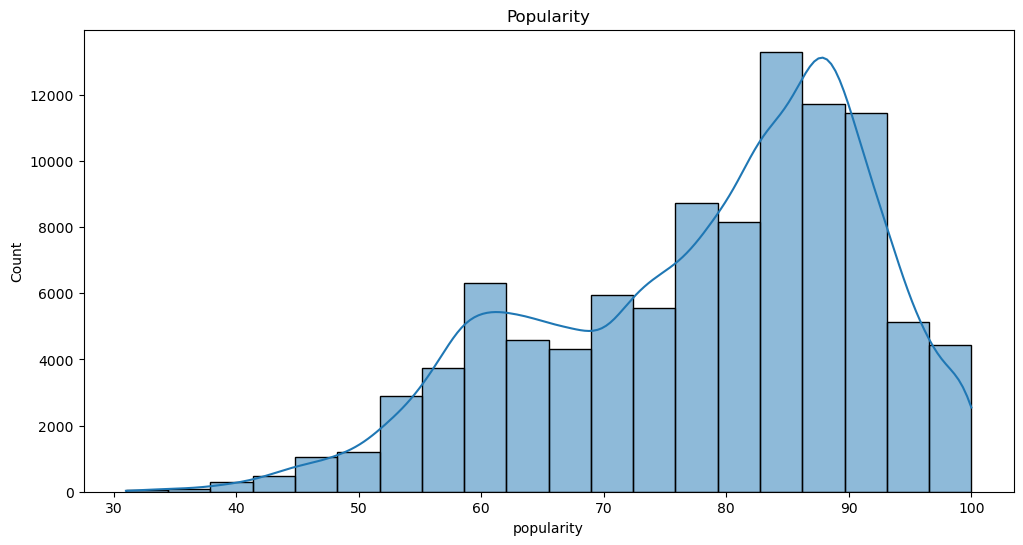

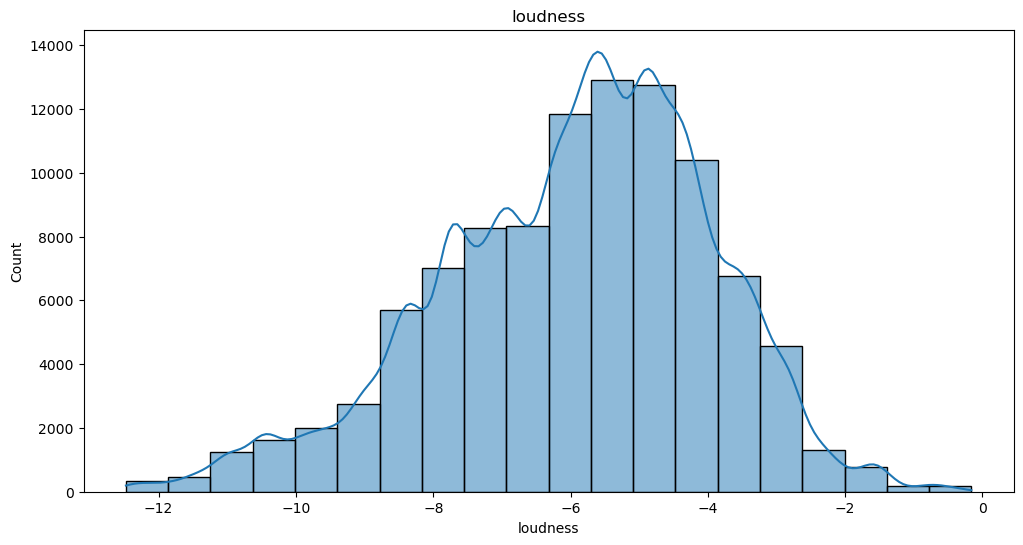

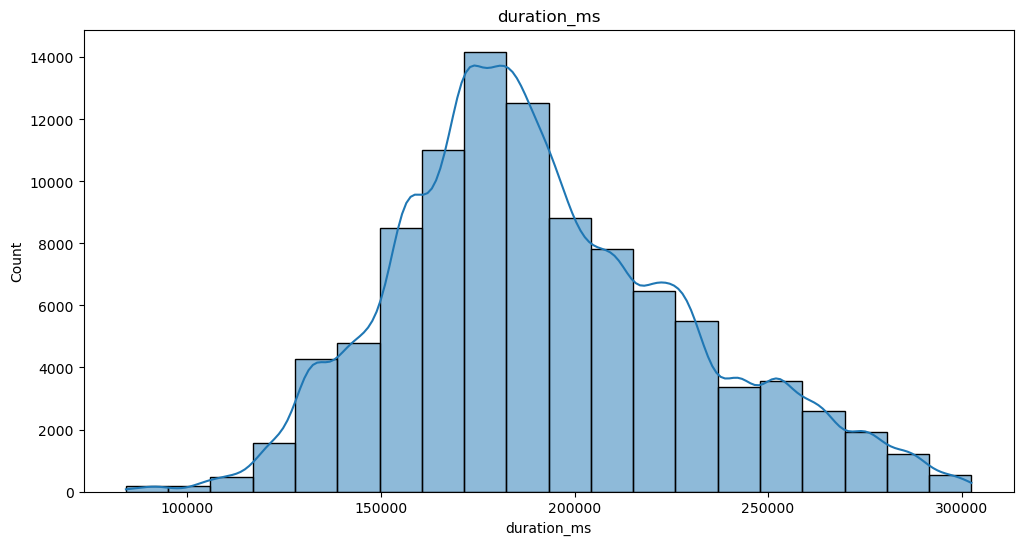

In [7]:

sample_num = df_clean.select(numeric_cols).sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(12,6))
sns.histplot(sample_num["popularity"], bins=20, kde=True)
plt.title("Popularity")
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(sample_num["loudness"], bins=20, kde=True)
plt.title("loudness")
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(sample_num["duration_ms"], bins=20, kde=True)
plt.title("duration_ms")
plt.show()

Визуализация категориальных признаков

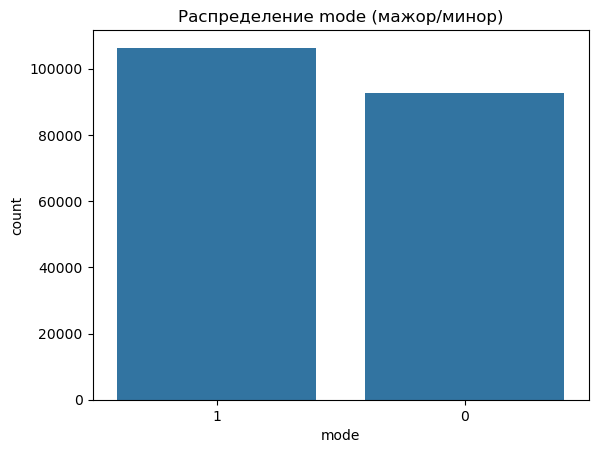

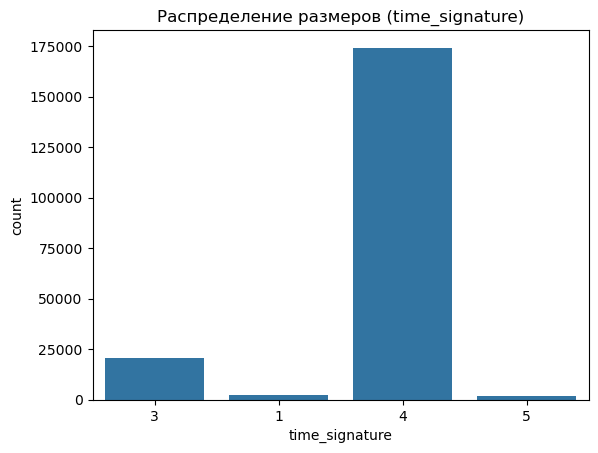

In [8]:

sample_mode = df_clean.select("mode").sample(fraction=0.2, seed=42).toPandas()
sns.countplot(x="mode", data=sample_mode)
plt.title("Распределение mode (мажор/минор)")
plt.show()

sample_ts = df_clean.select("time_signature").sample(fraction=0.2, seed=42).toPandas()
sns.countplot(x="time_signature", data=sample_ts)
plt.title("Распределение размеров (time_signature)")
plt.show()


Корреляции числовых признаков

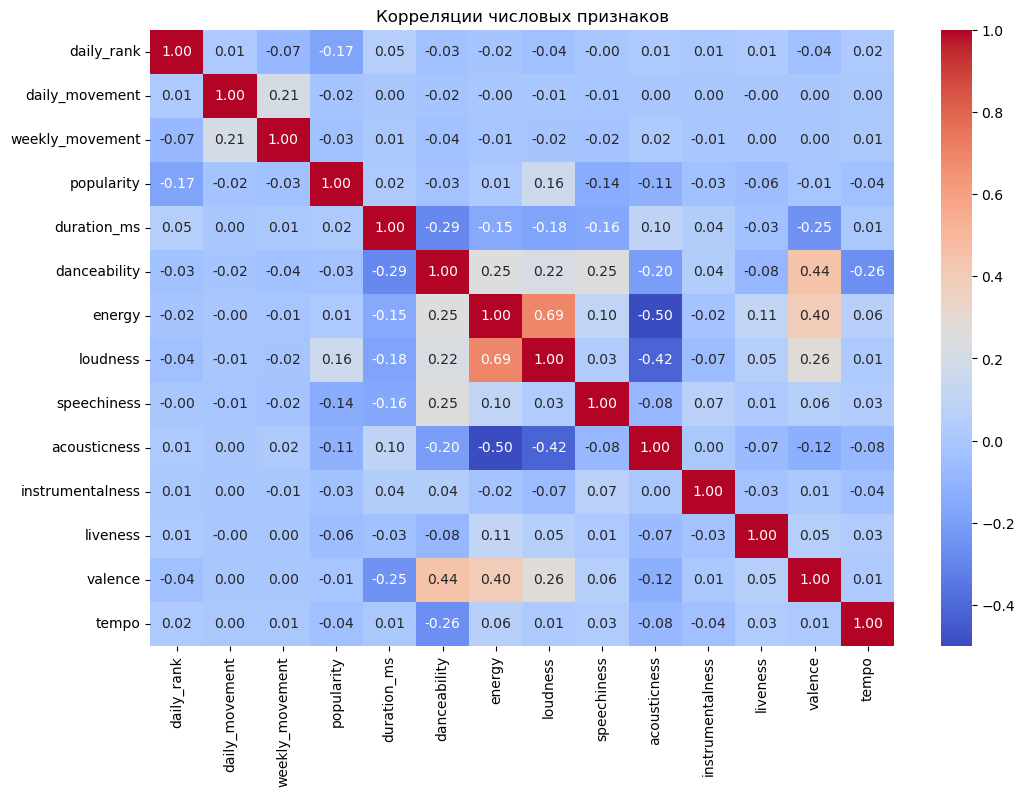

In [9]:

sample_corr = df_clean.select(numeric_cols).sample(fraction=0.1, seed=42).toPandas()
corr_matrix = sample_corr.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляции числовых признаков")
plt.show()
